Mount the Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Useful imports and plotting functions

In [ ]:
%matplotlib inline

# Python 2/3 compatibility
from __future__ import print_function, division

import itertools
import time

import numpy as np
import matplotlib.pyplot as plt

# Colors from Colorbrewer Paired_12
colors = [[31, 120, 180], [51, 160, 44]]
colors = [(r / 255, g / 255, b / 255) for (r, g, b) in colors]

# functions to show an image
def imshow(img):
    """
    :param img: (PyTorch Tensor)
    """
    # unnormalize
    img = img / 2 + 0.5     
    # Convert tensor to numpy array
    npimg = img.numpy()
    # Color channel first -> color channel last
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


def plot_losses(train_history, val_history):
    x = np.arange(1, len(train_history) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(x, train_history, color=colors[0], label="Training loss", linewidth=2)
    plt.plot(x, val_history, color=colors[1], label="Validation loss", linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title("Evolution of the training and validation loss")
    plt.show()

In [ ]:
import time
import numpy as np

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

## PART A. Improving CIFAR-10 Recognition Accuracy with State-of-the-art CNN

### 1. Loading and normalizing CIFAR10 Dataset

Seed the random generator to have reproducible results:


In [ ]:
seed = 5678
np.random.seed(seed)
torch.manual_seed(seed)

if torch.cuda.is_available():
  # Make CuDNN Determinist
  torch.backends.cudnn.deterministic = True
  torch.cuda.manual_seed(seed)

# Define default device, we should use the GPU (cuda) if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Define subset of the dataset (so it is faster to train)

In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler

n_training_samples = 50000 # Max: 50 000 - n_val_samples
n_val_samples = 0
n_test_samples = 10000

train_sampler = SubsetRandomSampler(np.arange(n_training_samples, dtype=np.int64))
val_sampler = SubsetRandomSampler(np.arange(n_training_samples, n_training_samples + n_val_samples, dtype=np.int64))
test_sampler = SubsetRandomSampler(np.arange(n_test_samples, dtype=np.int64))
# (In the last case, indexes do not need to account for training ones because the train=False parameter in datasets.CIFAR will select from the test set)

Data augmentation and Normalization

In [ ]:
num_workers = 2
test_batch_size = 4

transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.RandomCrop(size=32,padding=4),
     transforms.ToTensor(),
     transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))])

train_set = torchvision.datasets.CIFAR10(root='/content/drive/My Drive/Colab Notebooks', train=True,
                                        download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=test_batch_size, sampler=train_sampler,
                                          num_workers=num_workers)

test_set = torchvision.datasets.CIFAR10(root='/content/drive/My Drive/Colab Notebooks', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=test_batch_size, sampler=test_sampler,
                                         num_workers=num_workers)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Numbers of training, validation, testing samples

In [ ]:
print(len(train_set))
print(len(val_sampler))
print(len(test_set))

50000
0
10000


### 2.Network Setting - ResNet

In [ ]:
def _weights_init(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='A'):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(lambda x:
                                            F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)

        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

net = ResNet(BasicBlock, [3, 3, 3])
print(net)

if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=

### 3. Define a loss function and optimizer

In [ ]:
import torch.optim as optim

def createLossAndOptimizer(net, learning_rate=0.001):
    # it combines softmax with negative log likelihood loss
    criterion = nn.CrossEntropyLoss()  
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    return criterion, optimizer

### 4. Train the network


This is when things start to get interesting.
We simply have to loop over our data iterator, feed the inputs to the network, and optimize



#### Data loader

In [ ]:
def get_train_loader(batch_size):
    return torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=train_sampler,
                                              num_workers=num_workers)

# Use larger batch size for validation to speed up computation
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, sampler=test_sampler,
                                          num_workers=num_workers)

#### Training loop
The training script: it takes ~10s per epoch with batch_size = 128

In [ ]:
def train(net, batch_size, n_epochs, learning_rate):
    """
    Train a neural network and print statistics of the training
    
    :param net: (PyTorch Neural Network)
    :param batch_size: (int)
    :param n_epochs: (int)  Number of iterations on the training set
    :param learning_rate: (float) learning rate used by the optimizer
    """
    print("===== HYPERPARAMETERS =====")
    print("batch_size=", batch_size)
    print("n_epochs=", n_epochs)
    print("learning_rate=", learning_rate)
    print("=" * 30)
    
    train_loader = get_train_loader(batch_size)
    n_minibatches = len(train_loader)

    criterion, optimizer = createLossAndOptimizer(net, learning_rate)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30,40], gamma=0.1, last_epoch=-1)
    # Init variables used for plotting the loss
    train_history = []
    val_history = []

    training_start_time = time.time()
    best_error = np.inf
    best_model_path = "/content/drive/My Drive/Colab Notebooks/best_model.pth"
    
    # Move model to gpu if possible
    net = net.to(device)

    for epoch in range(n_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        print_every = n_minibatches // 10
        start_time = time.time()
        total_train_loss = 0
        
        for i, (inputs, labels) in enumerate(train_loader):

            # Move tensors to correct device
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            total_train_loss += loss.item()

            # print every 10th of epoch
            if (i + 1) % (print_every + 1) == 0:    
                print("Epoch {}, {:d}% \t train_loss: {:.2f} took: {:.2f}s".format(
                      epoch + 1, int(100 * (i + 1) / n_minibatches), running_loss / print_every,
                      time.time() - start_time))
                running_loss = 0.0
                start_time = time.time()

        train_history.append(total_train_loss / len(train_loader))

        total_val_loss = 0
        # Do a pass on the validation set
        # We don't need to compute gradient, so we use torch.no_grad() to save memory and computation
        with torch.no_grad():
          for inputs, labels in test_loader:
              inputs, labels = inputs.to(device), labels.to(device)
              predictions = net(inputs)
              val_loss = criterion(predictions, labels)
              total_val_loss += val_loss.item()
            
        val_history.append(total_val_loss / len(test_loader))
        # Save model that performs best on validation set
        if total_val_loss < best_error:
            best_error = total_val_loss
            torch.save(net.state_dict(), best_model_path)

        print("Validation loss = {:.2f}".format(total_val_loss / len(test_loader)))
        scheduler.step()

    print("Training Finished, took {:.2f}s".format(time.time() - training_start_time))
    
    # Load best model
    net.load_state_dict(torch.load(best_model_path))

    return train_history, val_history
    
# train the model
train_history, val_history = train(net, batch_size=128, n_epochs=50, learning_rate=0.01)

===== HYPERPARAMETERS =====
batch_size= 128
n_epochs= 50
learning_rate= 0.01
Epoch 1, 10% 	 train_loss: 2.32 took: 2.25s
Epoch 1, 20% 	 train_loss: 1.93 took: 1.95s
Epoch 1, 30% 	 train_loss: 1.85 took: 2.04s
Epoch 1, 40% 	 train_loss: 1.76 took: 1.96s
Epoch 1, 51% 	 train_loss: 1.74 took: 1.92s
Epoch 1, 61% 	 train_loss: 1.66 took: 2.00s
Epoch 1, 71% 	 train_loss: 1.63 took: 1.98s
Epoch 1, 81% 	 train_loss: 1.57 took: 1.98s
Epoch 1, 92% 	 train_loss: 1.52 took: 1.97s
Validation loss = 1.40
Epoch 2, 10% 	 train_loss: 1.39 took: 2.17s
Epoch 2, 20% 	 train_loss: 1.38 took: 2.00s
Epoch 2, 30% 	 train_loss: 1.34 took: 2.01s
Epoch 2, 40% 	 train_loss: 1.32 took: 1.97s
Epoch 2, 51% 	 train_loss: 1.27 took: 2.04s
Epoch 2, 61% 	 train_loss: 1.26 took: 1.98s
Epoch 2, 71% 	 train_loss: 1.22 took: 1.98s
Epoch 2, 81% 	 train_loss: 1.18 took: 2.01s
Epoch 2, 92% 	 train_loss: 1.16 took: 1.99s
Validation loss = 1.09
Epoch 3, 10% 	 train_loss: 1.09 took: 2.27s
Epoch 3, 20% 	 train_loss: 1.10 took: 2.0

Now, let's look at the plot of the training loss and validation loss as a function of the number of epochs.

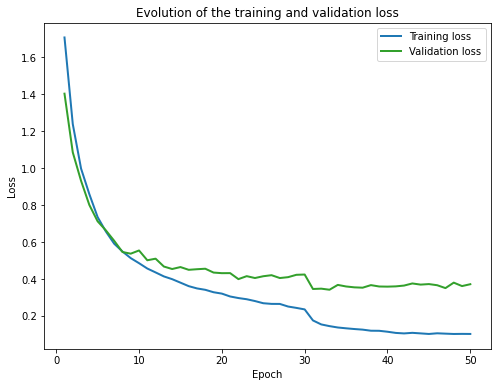

In [ ]:
plot_losses(train_history, val_history)

5. Test the network on the test data

The outputs are energies for the 10 classes.
The higher the energy for a class, the more the network
thinks that the image is from that particular class.
So, let's get the index of the highest energy:



Finally, let us look at how the network performs on the whole test set.

In [ ]:
def dataset_accuracy(net, data_loader, name=""):
    net.eval()
    net = net.to(device)
    correct = 0
    total = 0
    for images, labels in data_loader:
      images, labels = images.to(device), labels.to(device)
      outputs = net(images)
      _,predictions = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predictions == labels).sum()
      
    accuracy = 100 * float(correct) / total
    print('Accuracy of the network on the {} {} images: {:.2f} %'.format(total, name, accuracy))

def train_set_accuracy(net):
    dataset_accuracy(net, train_loader, "train")

def test_set_accuracy(net):
    dataset_accuracy(net, test_loader, "test")

def compute_accuracy(net):
    train_set_accuracy(net)
    test_set_accuracy(net)
    
print("Computing accuracy...")
compute_accuracy(net)

Computing accuracy...
Accuracy of the network on the 50000 train images: 95.67 %
Accuracy of the network on the 10000 test images: 89.82 %
